# Tuning RBF SVR models and testing them against external datasets

## Setting up

In [1]:
# setting up
# imports
import pyreadr
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.svm import SVR, LinearSVR
from sklearn.multioutput import MultiOutputRegressor

# calculate the mean of the pearson coefficients of multiple variables
def pair_pearsonr(x, y, axis=0): # this will allow us to take the pearson coefficient across two variables
    mx = np.mean(x, axis=axis, keepdims=True)
    my = np.mean(y, axis=axis, keepdims=True)
    xm, ym = x-mx, y-my
    r_num = np.add.reduce(xm * ym, axis=axis)
    r_den = np.sqrt((xm*xm).sum(axis=axis) * (ym*ym).sum(axis=axis))
    r = r_num / r_den
    return r

# plotting setup
# Use LaTeX for graphs' text
plt.rc('text', usetex=True)
# Use the serif font
plt.rc('font', family='serif')

In [2]:
# import data, access pandas df via key "None"
X_Govaere = pyreadr.read_r("datasets/X_Govaere.rds")[None]
X_Hoang = pyreadr.read_r("datasets/X_Hoang.rds")[None]
X_Pantano = pyreadr.read_r("datasets/X_Pantano.rds")[None]

# actual, clinical results
Y_Govaere = pyreadr.read_r("datasets/Y_Govaere.rds")[None]
Y_Hoang = pyreadr.read_r("datasets/Y_Hoang.rds")[None]
Y_Pantano = pyreadr.read_r("datasets/Y_Pantano.rds")[None]

# viper metric, predicted results
Y_viper_Govaere = pyreadr.read_r("datasets/viper_X_Govaere.rds")[None]
Y_viper_Hoang = pyreadr.read_r("datasets/viper_X_Hoang.rds")[None]
Y_viper_Pantano = pyreadr.read_r("datasets/viper_X_Pantano.rds")[None]

In [19]:
# setup tuning procedure
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# select our training dataset
datasets = {
    "Govaere": [X_Govaere, Y_Govaere],
    "Hoang": [X_Hoang, Y_Hoang],
    "Pantano": [X_Pantano, Y_Pantano]
}

# TODO: CHANGE THE FOLLOWING 3 LINES
training_dataset = "Pantano"
test1 = "Govaere"
test2 = "Hoang"

X, Y = datasets[training_dataset]
X_test1, Y_test1 = datasets[test1]
X_test2, Y_test2 = datasets[test2]

unique, freq = np.unique(Y.iloc[:,0], return_counts=True)
print(f"Unique NAS scores and their corresponding frequency:\n{[f'{(i,j)}' for i, j in zip(unique, freq)]}")
unique, freq = np.unique(Y.iloc[:,1], return_counts=True)
print(f"Unique Fibrosis scores and their corresponding frequency:\n{[f'{(i,j)}' for i, j in zip(unique, freq)]}")


Unique NAS scores and their corresponding frequency:
['(0.0, 32)', '(1.0, 12)', '(2.0, 9)', '(3.0, 11)', '(4.0, 13)', '(5.0, 18)', '(6.0, 12)', '(7.0, 9)']
Unique Fibrosis scores and their corresponding frequency:
['(0.0, 57)', '(1.0, 25)', '(2.0, 25)', '(3.0, 5)', '(4.0, 4)']


In [4]:
# select one of the following:
# linear SVM
# params = {
#             'epsilon': [0,1e-4,1e-3,1e-2,1e-1,1],
#             'C': [1e-1,1, 10, 100, 1000]
#             }

# model = GridSearchCV(estimator=LinearSVR(dual=False),param_grid = params, cv=5, n_jobs=-1)
# model = MultiOutputRegressor(model)

# # radial basis function SVM
params = {
            'gamma': [1e-5,1e-4,1e-3,1e-2,1e-1,1,1.5,2],
            'C': [1e-1,1, 10, 100, 1000]
            }
model = GridSearchCV(estimator=SVR(kernel='rbf'),param_grid = params, cv=5, n_jobs=-1)
model = MultiOutputRegressor(model)

# # polynomial SVM
# params = {
#             'gamma': [1e-5,1e-4,1e-3,1e-2,1e-1,1,1.5,2],
#             'C': [1e-1,1, 10, 100, 1000],
#             'degree':[2,3,4,5],
#             'coef0':[0,0.1,0.5,1.,1.2,2.]
#             }
# model = GridSearchCV(estimator=SVR(kernel='poly'),param_grid = params, cv=5, n_jobs=-1)
# model = MultiOutputRegressor(model)

## Perform cross validation to find ideal hyperparameters

In [20]:
# For storing fold results
best_params_list = []
test_pearson_coeff_fib = []
test_pearson_coeff_nas = []

# K-fold split for the dataset
for i, (train_index, test_index) in enumerate(skf.split(X, Y[Y.columns[1]])):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit model and get best parameters
    model.fit(X_train, Y_train)
    Y_test_hat = model.predict(X_test)

    # Calculate Pearson correlation for each phenotype
    corr_test_fib, _ = pearsonr(Y_test.values[:, 0], Y_test_hat[:, 0])  # fibrosis correlation
    corr_test_nas, _ = pearsonr(Y_test.values[:, 1], Y_test_hat[:, 1])  # NAS correlation
    test_pearson_coeff_fib.append(corr_test_fib)
    test_pearson_coeff_nas.append(corr_test_nas)

    fold_best_params = [est.best_params_ for est in model.estimators_]
    best_params_list.append(fold_best_params)

# Optionally, average correlations over folds
mean_corr_fib = np.mean(test_pearson_coeff_fib)
mean_corr_nas = np.mean(test_pearson_coeff_nas)

print(f"Mean Pearson correlation (Fibrosis): {mean_corr_fib}")
print(f"Mean Pearson correlation (NAS): {mean_corr_nas}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Mean Pearson correlation (Fibrosis): 0.6916235580225856
Mean Pearson correlation (NAS): 0.6694261470882986


In [32]:
best_params = best_params_list[np.argmax(sum(i,j)/2 for i,j in zip(test_pearson_coeff_fib, test_pearson_coeff_nas))]
best_params

[{'C': 100, 'gamma': 0.0001}, {'C': 10, 'gamma': 1e-05}]

## Select best hyperparameters, retrain, and save the model

In [29]:
# save the model so we can run it again
# this time, store the pearson's coeff for training and validation sets

# creating a better all_coeff dataframe

X_shuffled = X.apply(lambda col: np.random.permutation(col.values), axis=0)
X_shuffled.index = X.index # ensure the gene names are maintained

results = [] # initialize list of all results

model = GridSearchCV(estimator=SVR(kernel='rbf'),param_grid = params, cv=5, n_jobs=-1)
model = MultiOutputRegressor(model)

for i, (train_index, test_index) in enumerate(skf.split(X, Y[Y.columns[1]])):

    # split data
    X_train = X.iloc[train_index]
    X_val = X.iloc[test_index]
    Y_train = Y.iloc[train_index]
    Y_val = Y.iloc[test_index]

    partitions = [[X_train, X_val, X_test1, X_test2, X_shuffled], [Y_train, Y_val, Y_test1, Y_test2, Y], ["Train", "Validation", test1, test2, "Shuffled"]]

    print(f'Evaluating fold {i}')
    model.fit(X_train, Y_train)

    for j in range(len(partitions[0])):
        
        Y_hat = model.predict(partitions[0][j])
        corr_nas, _ = pearsonr(partitions[1][j].values[:,0], Y_hat[:,0]) # NAS correlation
        corr_fib, _ = pearsonr(partitions[1][j].values[:,1], Y_hat[:,1]) # fibrosis correlation
        corr_mean = np.mean(pair_pearsonr(partitions[1][j].values, Y_hat)) # mean correlation
        
        results.append({
            "TuningDataset": training_dataset,
            "Fold": f"Fold{i+1}",
            "Partition": partitions[2][j],
            "Phenotype": "Fibrosis", 
            "Pearson_Coefficient": corr_fib,
            "C": best_params[1]["C"],
            "gamma": best_params[1]["gamma"]
        })
        results.append({
            "TuningDataset": training_dataset,
            "Fold": f"Fold{i+1}",
            "Partition": partitions[2][j],
            "Phenotype": "NAS",
            "Pearson_Coefficient": corr_nas,
            "C": best_params[0]["C"],
            "gamma": best_params[0]["gamma"]
        })
        results.append({
            "TuningDataset": training_dataset,
            "Fold": f"Fold{i+1}",
            "Partition": partitions[2][j],
            "Phenotype": "Combined",
            "Pearson_Coefficient": corr_mean,
            # "alpha": best_params["alpha"],
            # "L1_ratio": best_params["l1_ratio"]
        })

    filename = f"models/{training_dataset}_rbfSVR_fold_{i}.pkl" # TODO: CHANGE
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    
    print(f"Model for Fold {i} saved as {filename}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Evaluating fold 0
Model for Fold 0 saved as models/Pantano_rbfSVR_fold_0.pkl
Evaluating fold 1
Model for Fold 1 saved as models/Pantano_rbfSVR_fold_1.pkl
Evaluating fold 2
Model for Fold 2 saved as models/Pantano_rbfSVR_fold_2.pkl
Evaluating fold 3
Model for Fold 3 saved as models/Pantano_rbfSVR_fold_3.pkl
Evaluating fold 4
Model for Fold 4 saved as models/Pantano_rbfSVR_fold_4.pkl


In [30]:
curr = pd.DataFrame(results)

# new = pd.concat([g, h, p])
# new.to_csv("datasets/rbfSVR_pearson_coefficients.csv", index=False)

In [25]:
# g = curr
# h = curr
p = curr

In [11]:
g

,TuningDataset,Fold,Partition,Phenotype,Pearson_Coefficient,C,gamma
0,Govaere,Fold1,Train,Fibrosis,0.995322,100.0,0.00001
1,Govaere,Fold1,Train,NAS,0.982007,100.0,0.00001
2,Govaere,Fold1,Train,Combined,0.988664,NaN,NaN
3,Govaere,Fold1,Validation,Fibrosis,0.736271,100.0,0.00001
4,Govaere,Fold1,Validation,NAS,0.600718,100.0,0.00001
...,...,...,...,...,...,...,...
70,Govaere,Fold5,Pantano,NAS,0.616389,100.0,0.00001
71,Govaere,Fold5,Pantano,Combined,0.633784,NaN,NaN
72,Govaere,Fold5,Shuffled,Fibrosis,0.015126,100.0,0.00001
73,Govaere,Fold5,Shuffled,NAS,-0.054035,100.0,0.00001


In [18]:
h

,TuningDataset,Fold,Partition,Phenotype,Pearson_Coefficient,C,gamma
0,Hoang,Fold1,Train,Fibrosis,0.997515,100.0,0.00001
1,Hoang,Fold1,Train,NAS,0.998709,100.0,0.00010
2,Hoang,Fold1,Train,Combined,0.998112,NaN,NaN
3,Hoang,Fold1,Validation,Fibrosis,0.834607,100.0,0.00001
4,Hoang,Fold1,Validation,NAS,0.602199,100.0,0.00010
...,...,...,...,...,...,...,...
70,Hoang,Fold5,Pantano,NAS,0.412667,100.0,0.00010
71,Hoang,Fold5,Pantano,Combined,0.369683,NaN,NaN
72,Hoang,Fold5,Shuffled,Fibrosis,0.097557,100.0,0.00001
73,Hoang,Fold5,Shuffled,NAS,0.017797,100.0,0.00010


In [33]:
p

,TuningDataset,Fold,Partition,Phenotype,Pearson_Coefficient,C,gamma
0,Pantano,Fold1,Train,Fibrosis,0.872686,10.0,0.00001
1,Pantano,Fold1,Train,NAS,0.999639,100.0,0.00010
2,Pantano,Fold1,Train,Combined,0.936162,NaN,NaN
3,Pantano,Fold1,Validation,Fibrosis,0.676191,10.0,0.00001
4,Pantano,Fold1,Validation,NAS,0.604737,100.0,0.00010
...,...,...,...,...,...,...,...
70,Pantano,Fold5,Hoang,NAS,0.652205,100.0,0.00010
71,Pantano,Fold5,Hoang,Combined,0.604432,NaN,NaN
72,Pantano,Fold5,Shuffled,Fibrosis,-0.043137,10.0,0.00001
73,Pantano,Fold5,Shuffled,NAS,-0.181616,100.0,0.00010


In [31]:
curr

,TuningDataset,Fold,Partition,Phenotype,Pearson_Coefficient,C,gamma
0,Pantano,Fold1,Train,Fibrosis,0.872686,10.0,0.00001
1,Pantano,Fold1,Train,NAS,0.999639,100.0,0.00010
2,Pantano,Fold1,Train,Combined,0.936162,NaN,NaN
3,Pantano,Fold1,Validation,Fibrosis,0.676191,10.0,0.00001
4,Pantano,Fold1,Validation,NAS,0.604737,100.0,0.00010
...,...,...,...,...,...,...,...
70,Pantano,Fold5,Hoang,NAS,0.652205,100.0,0.00010
71,Pantano,Fold5,Hoang,Combined,0.604432,NaN,NaN
72,Pantano,Fold5,Shuffled,Fibrosis,-0.012560,10.0,0.00001
73,Pantano,Fold5,Shuffled,NAS,-0.009735,100.0,0.00010


In [ ]:
# load all models
loaded_models = []
for i in range(0, 5):
    filename = f"models/{training_dataset}_rbfSVR_fold_{i}.pkl"
    with open(filename, 'rb') as file:
        model = pickle.load(file)
        loaded_models.append(model)
    print(f"Loaded model {i} from {filename}")

## Test with the best model on external and shuffled datasets

## Plot with Mann-Whitney test

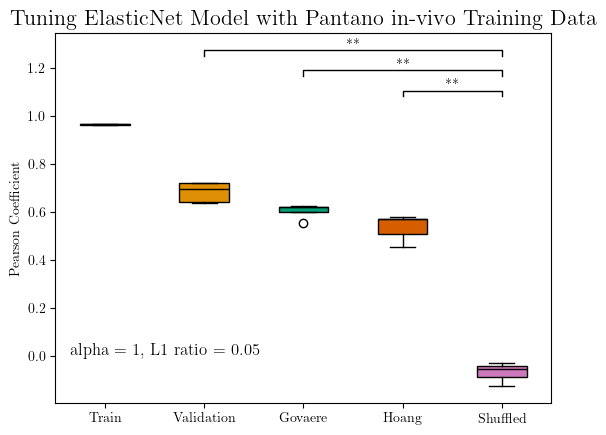

In [138]:
significant_combinations = []

combinations = [(x, 4) for x in [1, 2, 3]]
for combo in combinations:
    data1 = all_pearsons_coeff.iloc[:,combo[0]]
    data2 = all_pearsons_coeff.iloc[:,combo[1]]
    
    # calculate significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    if p < 0.05:
        significant_combinations.append([combo, p])

# create a set of axes
ax = plt.axes()
# create a boxplot on the axes
bp = ax.boxplot(all_pearsons_coeff, patch_artist=True)
# graph title TODO: CHANGE
ax.set_title(f"Tuning ElasticNet Model with {training_dataset} in-vivo Training Data", fontsize=16)
# label y-axis
ax.set_ylabel("Pearson Coefficient")

xticklabels = all_pearsons_coeff.columns.tolist()
ax.set_xticklabels(xticklabels)

# Change the colour of the boxes to Seaborn's 'pastel' palette
colors = sns.color_palette('colorblind')
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Colour of the median lines
plt.setp(bp['medians'], color='k')

# Get the y-axis limits
bottom, top = ax.get_ylim()
y_range = top - bottom

# Significance bars
for i, significant_combination in enumerate(significant_combinations):
    # Columns corresponding to the datasets of interest
    # add one because the df indexing is 0 indexed, but plot is 1 indexed
    x1 = significant_combination[0][0] + 1 
    x2 = significant_combination[0][1] + 1
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
    # Plot the bar
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')

# label the hyperparameter value
plt.text(0.65, 0.00, f'alpha = {best_params["alpha"]}, L1 ratio = {best_params["l1_ratio"]}', fontsize = 12)

#TODO: CHANGE
plt.savefig(f'graphs/ElasticNet_tuning_with_{training_dataset}.png', dpi=200)
plt.show()

In [86]:
significant_combinations

[[(1, 4), 0.007936507936507936],
 [(2, 4), 0.007936507936507936],
 [(3, 4), 0.007936507936507936]]